# 00_Feature_ — 파생변수별 Voting Rate 시각화
- 02/03/04에서 사용한 파생변수 기준으로 voting rate 차이를 한눈에 확인
- 수치형은 구간화(분위수), 범주형은 카테고리별 평균

- y축 voting rate는 voted==1(투표함) 비율로 계산


# 피처 설명 (의미/계산 방식)

## Q_A 태도 요약
- **neg_att**: QbA, QcA, QjA, QmA, QoA, QsA 평균
  - 냉소/불신/규범 회피 성향 요약
- **pos_att**: QkA, QqA 평균
  - 도덕성/사회적 신뢰 성향 요약

## 확신/중도 비율
- **neutral_ratio**: (QeA, QfA, QhA, QrA 중 3점 비율)
- **confident_ratio**: (QeA, QfA, QhA, QrA 중 1–2 또는 4–5 비율)
- 결측은 **응답한 문항 기준**으로 비율 계산

## Q_A 결측 비율
- **qa_missing_ratio**: 전체 Q_A 문항 중 무응답 비율

## Big5 성향
- **diff**: (정방향 − 역방향) 점수
- **strength**: |diff| (강도)

## 단어 인지
- **wr_sum**: 실제 단어 인지 합
- **wf_sum**: 가짜 단어 착각 합
- **word_credibility** = wr_sum − wf_sum
- **cred_bin**: word_credibility를 Low/Mid/High 구간화

## 인구통계/범주형
- **age_group_ord**: 연령대 순서형 수치화
- **education**: 학력 (0=무응답은 결측 처리)
- **urban_ord**: 거주 형태 순서형
- **hand_cat / married_cat / race / religion**: 원본 카테고리 유지


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


## 1. 데이터 로드


In [16]:
train = pd.read_csv("../../data/raw/train.csv")

## 2. 공통 파생변수 생성 (원본 카테고리 사용)


In [17]:
def build_features(df_raw, cfg=None, is_train=True):
    df = df_raw.copy()

    if is_train and "voted" in df.columns:
        df["voted_bin"] = (df["voted"] == 1).astype(int)

    if "age_group" in df.columns:
        age_map = {"10s":1, "20s":2, "30s":3, "40s":4, "50s":5, "60s":6, "+70s":7}
        df["age_group_ord"] = df["age_group"].map(age_map).astype("float32")

    if "education" in df.columns:
        df["education"] = pd.to_numeric(df["education"], errors="coerce")
        df.loc[df["education"] == 0, "education"] = np.nan
        df["education"] = df["education"].astype("float32")

    if "married" in df.columns:
        df["married"] = pd.to_numeric(df["married"], errors="coerce")
        df.loc[df["married"] == 0, "married"] = np.nan
        df["married_cat"] = df["married"].astype("string")

    if "hand" in df.columns:
        df["hand"] = pd.to_numeric(df["hand"], errors="coerce")
        df.loc[df["hand"] == 0, "hand"] = np.nan
        df["hand_cat"] = df["hand"].astype("string")

    if "urban" in df.columns:
        df["urban"] = pd.to_numeric(df["urban"], errors="coerce")
        df.loc[df["urban"] == 0, "urban"] = np.nan
        df["urban_ord"] = df["urban"].astype("float32")

    # race/religion: 원본 사용
    if "race" in df.columns:
        df["race"] = df["race"].astype("string")
    if "religion" in df.columns:
        df["religion"] = df["religion"].astype("string")

    neg_cols = ["QbA","QcA","QjA","QmA","QoA","QsA"]
    pos_cols = ["QkA","QqA"]
    other_cols = ["QeA","QfA","QhA","QrA"]

    qa_cols = [c for c in df.columns if c.startswith("Q") and c.endswith("A")]
    for col in qa_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        df.loc[df[col] == 0, col] = np.nan

    if all(c in df.columns for c in neg_cols):
        df["neg_att"] = df[neg_cols].mean(axis=1)

    if all(c in df.columns for c in pos_cols):
        df["pos_att"] = df[pos_cols].mean(axis=1)

    if all(c in df.columns for c in other_cols):
        other = df[other_cols]
        denom = other.notna().sum(axis=1)
        df["neutral_ratio"] = np.where(denom > 0, (other == 3).sum(axis=1) / denom, np.nan)
        df["confident_ratio"] = np.where(denom > 0, other.isin([1,2,4,5]).sum(axis=1) / denom, np.nan)

    if len(qa_cols) > 0:
        qa_mat = df[qa_cols]
        df["qa_missing_ratio"] = qa_mat.isna().sum(axis=1) / len(qa_cols)

    tp_pairs = {
        "extraversion": ("tp01", "tp06"),
        "agreeableness": ("tp07", "tp02"),
        "conscientiousness": ("tp03", "tp08"),
        "neuroticism": ("tp04", "tp09"),
        "openness": ("tp05", "tp10"),
    }
    for trait, (a, b) in tp_pairs.items():
        if a in df.columns and b in df.columns:
            df[a] = pd.to_numeric(df[a], errors="coerce")
            df[b] = pd.to_numeric(df[b], errors="coerce")
            df[f"{trait}_diff"] = (df[a] - df[b]).astype("float32")
            df[f"{trait}_strength"] = df[f"{trait}_diff"].abs().astype("float32")

    wr_cols = [f"wr_{i:02d}" for i in range(1, 14)]
    wf_cols = [f"wf_{i:02d}" for i in range(1, 4)]

    if all(c in df.columns for c in wr_cols):
        df["wr_sum"] = df[wr_cols].sum(axis=1).astype("float32")

    if all(c in df.columns for c in wf_cols):
        df["wf_sum"] = df[wf_cols].sum(axis=1).astype("float32")

    if "wr_sum" in df.columns and "wf_sum" in df.columns:
        df["word_credibility"] = (df["wr_sum"] - df["wf_sum"]).astype("float32")

    if "word_credibility" in df.columns:
        df["cred_bin"] = pd.cut(
            df["word_credibility"],
            bins=[-3, 1, 6, 13],
            labels=["Low", "Mid", "High"]
        )

    return df

cfg = {}
edu = pd.to_numeric(train["education"], errors="coerce").replace(0, np.nan)
cfg["education_mean"] = float(edu.mean())

df_feat = build_features(train, cfg=cfg, is_train=True)


## 3. 시각화 함수


In [18]:
# code -> label mapping (English)
LABEL_MAP = {
    "age_group_ord": {1:"10s", 2:"20s", 3:"30s", 4:"40s", 5:"50s", 6:"60s", 7:"70s+"},
    "education": {1:"<HS", 2:"HS", 3:"College", 4:"Grad"},
    "urban_ord": {1:"Rural", 2:"Suburban", 3:"Urban"},
    "hand_cat": {"1":"Right", "2":"Left", "3":"Both"},
    "married_cat": {"1":"Single", "2":"Married", "3":"Div/Wid"},
}

# quantile labels
QUANTILE_LABELS = ["Very Low", "Low", "Medium", "High", "Very High"]


def plot_numeric_binned(df, col, bins=5):
    s = df[[col, "voted_bin"]].dropna()

    # single value case
    if s[col].nunique() <= 1:
        out = s.groupby(col)["voted_bin"].agg(["mean", "count"]).reset_index()
        x = out[col].astype(str)
        plt.figure(figsize=(6, 3))
        ax = sns.barplot(x=x, y=out["mean"], color="#2c6faa")
        ax.set_title(f"Voting rate by {col} (single value)")
        ax.set_xlabel(col)
        ax.set_ylabel("Voting rate")
        ax.set_ylim(0, 1)
        for i, row in out.iterrows():
            ax.text(i, row["mean"] + 0.02, f"n={int(row['count'])}", ha="center", fontsize=9)
        plt.tight_layout()
        plt.show()
        return

    # small number of unique values -> show actual values
    if s[col].nunique() <= 5:
        out = s.groupby(col)["voted_bin"].agg(["mean", "count"]).reset_index()
        raw = out[col].astype(str)
        if col in LABEL_MAP:
            mapper = LABEL_MAP[col]
            x = raw.map(lambda v: mapper.get(int(float(v))) if v.replace('.0','').isdigit() else mapper.get(v, v))
        else:
            x = raw
        percent_note = ""
    else:
        s["bin"] = pd.qcut(s[col], q=bins, duplicates="drop")
        out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()
        x = QUANTILE_LABELS[:len(out)]
        percent_note = "Quantile split (each 20%)"

    plt.figure(figsize=(6, 3))
    ax = sns.barplot(x=x, y=out["mean"], color="#2c6faa")
    ax.set_title(f"Voting rate by {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Voting rate")
    ax.set_ylim(0, 1)
    if percent_note:
        ax.text(0.98, 0.95, percent_note, transform=ax.transAxes,
                ha="right", va="top", fontsize=9)
    ax.tick_params(axis='x', rotation=20)
    plt.tight_layout()
    plt.show()


def plot_categorical(df, col, top_n=12):
    s = df[[col, "voted_bin"]].dropna()
    out = s.groupby(col)["voted_bin"].agg(["mean", "count"]).reset_index()
    out = out.sort_values("count", ascending=False).head(top_n)

    if col in LABEL_MAP:
        mapper = LABEL_MAP[col]
        def map_label(v):
            try:
                iv = int(float(v))
                return mapper.get(iv, mapper.get(str(iv), v))
            except Exception:
                return mapper.get(v, v)
        out[col] = out[col].astype(str).map(map_label).fillna(out[col].astype(str))

    plt.figure(figsize=(7, 3))
    ax = sns.barplot(x=out[col].astype(str), y=out["mean"], color="#2c6faa")
    ax.set_title(f"Voting rate by {col} (top {top_n})")
    ax.set_xlabel(col)
    ax.set_ylabel("Voting rate")
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=30)
    plt.tight_layout()
    plt.show()


## 4. Q_A 태도 요약


**해석 가이드**
- **neg_att**: 냉소/사회적 불신 요약. 그래프에서 *높음* 구간일수록 투표율이 낮으면 부정 태도↑ → 투표↓ 경향
- **pos_att**: 도덕성/사회적 신뢰 요약. 그래프에서 *높음* 구간일수록 투표율이 높으면 긍정 태도↑ → 투표↑ 경향


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_80907/744043934.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


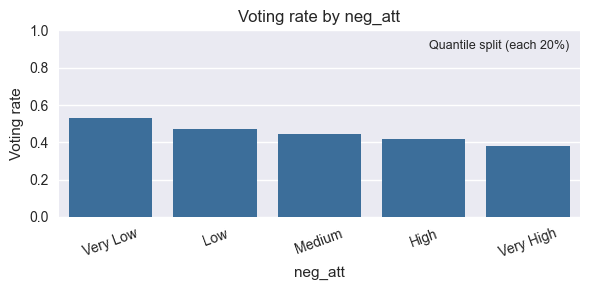

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_80907/744043934.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


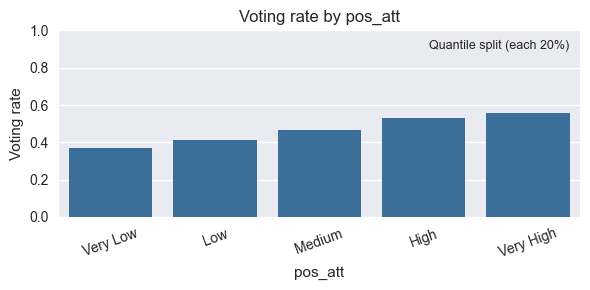

In [19]:
for col in ["neg_att", "pos_att"]:
    if col in df_feat.columns:
        plot_numeric_binned(df_feat, col, bins=5)


## 5. 확신/중도 비율 + 결측 비율


**해석 가이드**
- **neutral_ratio**: 3점(중도) 응답 비율. 높을수록 중도/무관심 성향으로 해석될 수 있음
- **confident_ratio**: 1–2/4–5 확신 응답 비율. 높을수록 확신 있는 응답 성향
- **qa_missing_ratio**: Q_A 무응답 비율. 높을수록 설문 응답 성실도 낮을 가능성


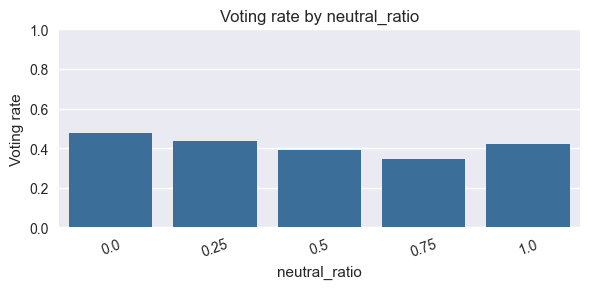

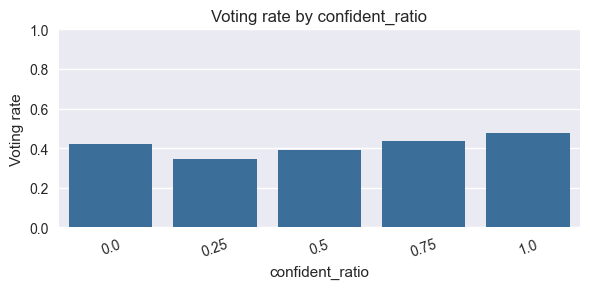

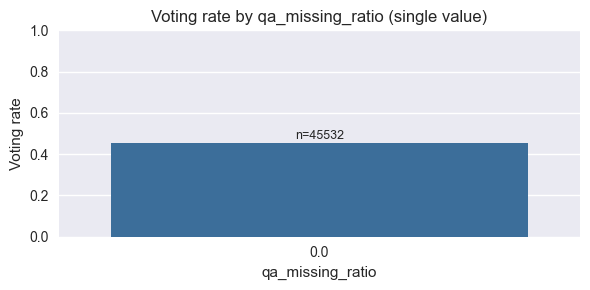

In [20]:
for col in ["neutral_ratio", "confident_ratio", "qa_missing_ratio"]:
    if col in df_feat.columns:
        plot_numeric_binned(df_feat, col, bins=5)


## 6. Big5 성향 (diff/strength)


**해석 가이드**
- **diff**: 성향 방향(정방향−역방향). 값이 클수록 해당 성향이 강한 방향
- **strength**: 강도(|diff|). 높을수록 성향이 강하게 드러남


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_80907/744043934.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


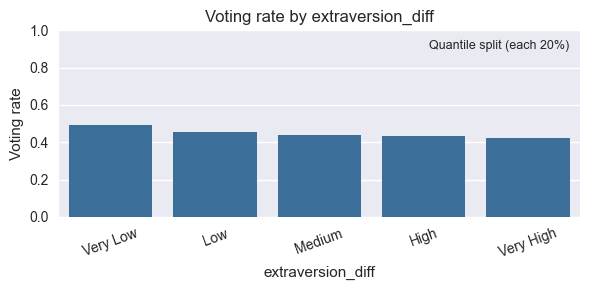

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_80907/744043934.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


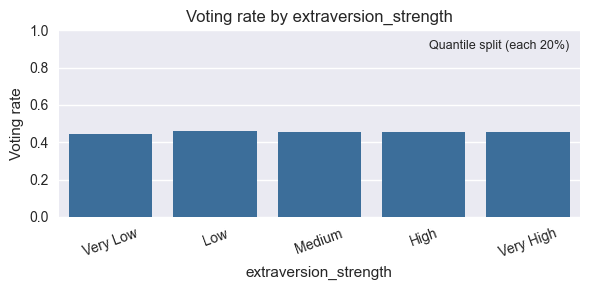

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_80907/744043934.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


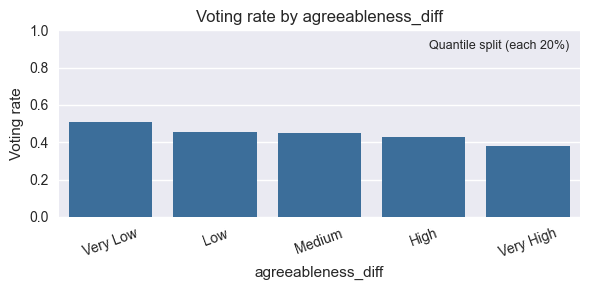

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_80907/744043934.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


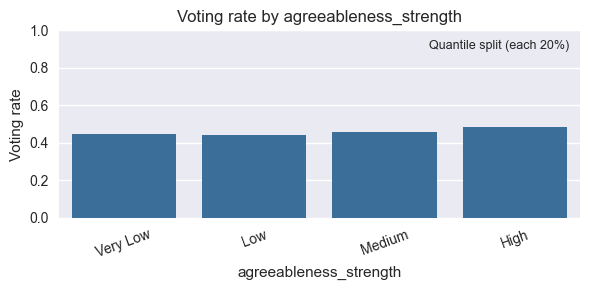

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_80907/744043934.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


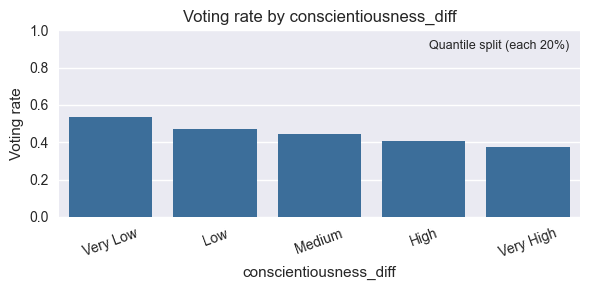

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_80907/744043934.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


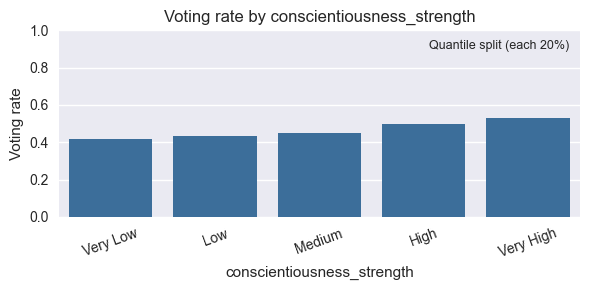

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_80907/744043934.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


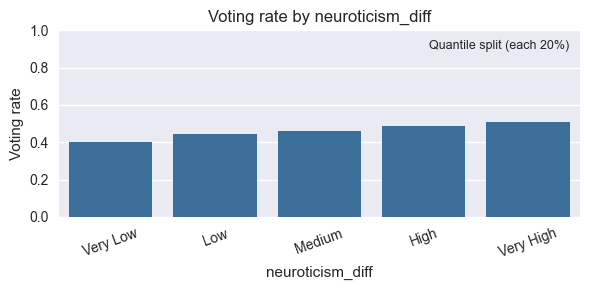

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_80907/744043934.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


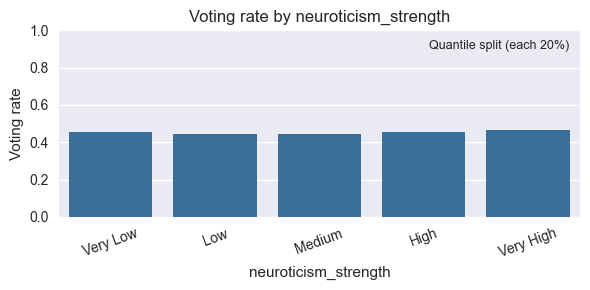

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_80907/744043934.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


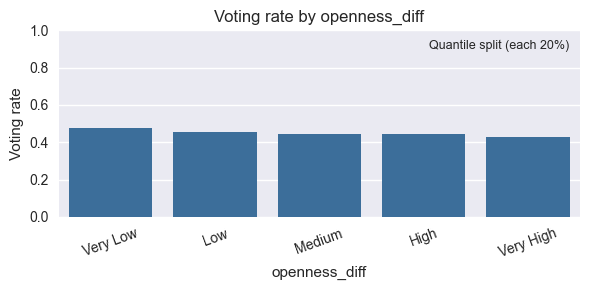

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_80907/744043934.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


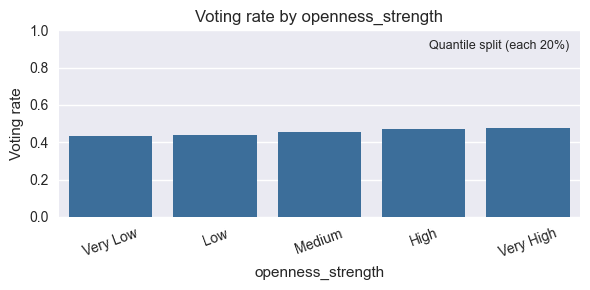

In [21]:
big5_cols = [
    "extraversion_diff", "extraversion_strength",
    "agreeableness_diff", "agreeableness_strength",
    "conscientiousness_diff", "conscientiousness_strength",
    "neuroticism_diff", "neuroticism_strength",
    "openness_diff", "openness_strength",
]
for col in big5_cols:
    if col in df_feat.columns:
        plot_numeric_binned(df_feat, col, bins=5)


## 7. 단어 인지


**해석 가이드**
- **wr_sum**: 실제 단어 인지 수(높을수록 인지력↑가능)
- **wf_sum**: 가짜 단어 착각 수(높을수록 혼동/부주의 가능)
- **word_credibility**: wr_sum − wf_sum. 높을수록 인지 신뢰도↑
- **cred_bin**: 인지 신뢰도를 Low/Mid/High로 구간화


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_80907/744043934.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


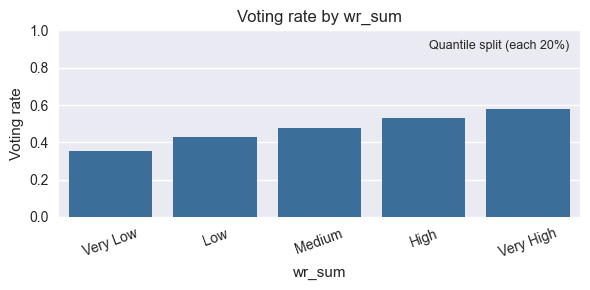

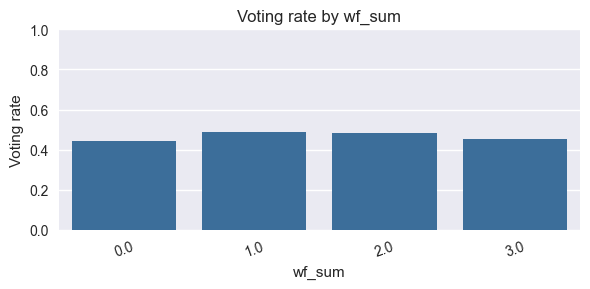

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_80907/744043934.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


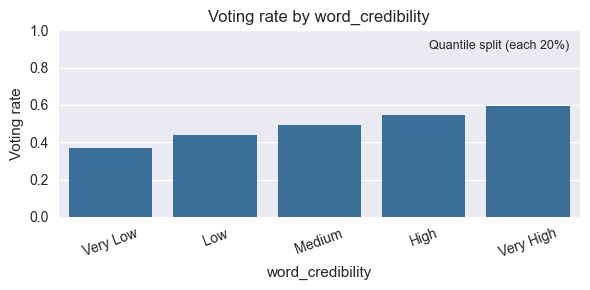

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_80907/744043934.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby(col)["voted_bin"].agg(["mean", "count"]).reset_index()


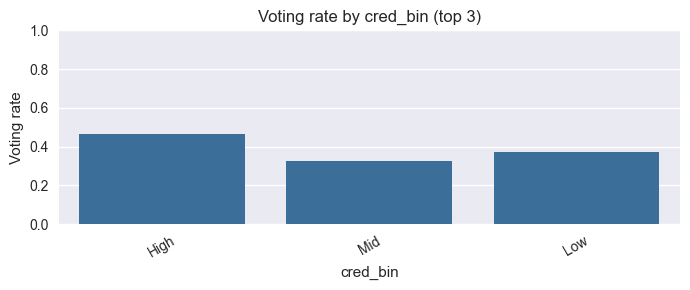

In [22]:
for col in ["wr_sum", "wf_sum", "word_credibility"]:
    if col in df_feat.columns:
        plot_numeric_binned(df_feat, col, bins=5)

if "cred_bin" in df_feat.columns:
    plot_categorical(df_feat, "cred_bin", top_n=3)


## 7-1. 단어 인지 비교 (같은 분위수 기준)


/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_80907/744043934.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


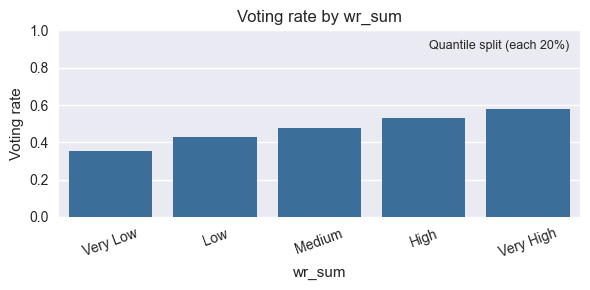

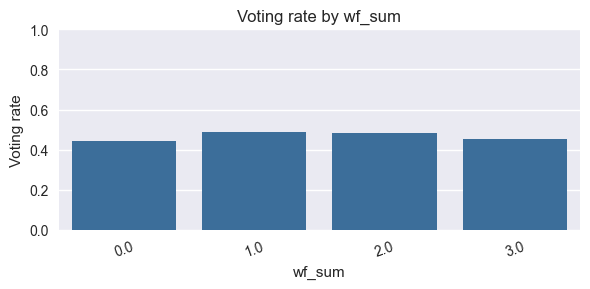

/var/folders/zb/7vcy0_ts23q_3pjlgfdd_cl80000gn/T/ipykernel_80907/744043934.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = s.groupby("bin")["voted_bin"].agg(["mean", "count"]).reset_index()


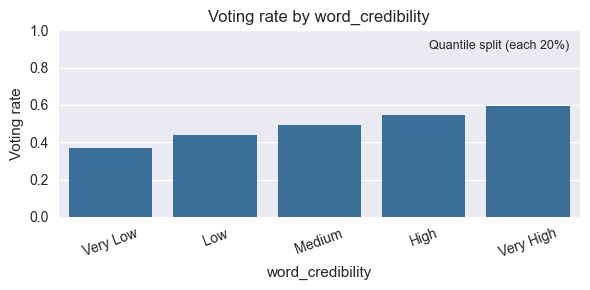

In [23]:
# 같은 분위수 기준으로 wr_sum / wf_sum / word_credibility 비교
for col in ["wr_sum", "wf_sum", "word_credibility"]:
    if col in df_feat.columns:
        plot_numeric_binned(df_feat, col, bins=5)


## 8. 인구통계 (수치/범주)


**해석 가이드**
- **age_group_ord**: 연령대 높을수록 투표율 상승 여부 확인
- **education**: 학력 수준별 투표율 차이 확인
- **urban_ord**: 거주 형태(시골/교외/도시)별 차이 확인
- **hand_cat / married_cat**: 손잡이/혼인상태별 투표율 차이 확인


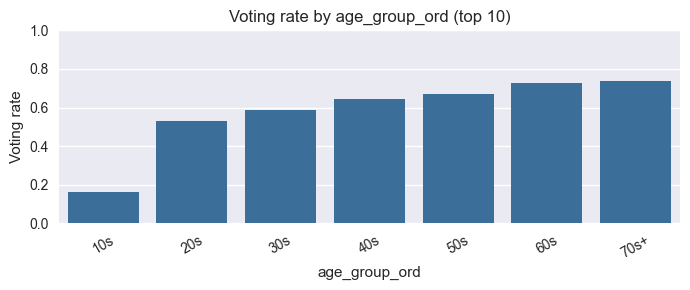

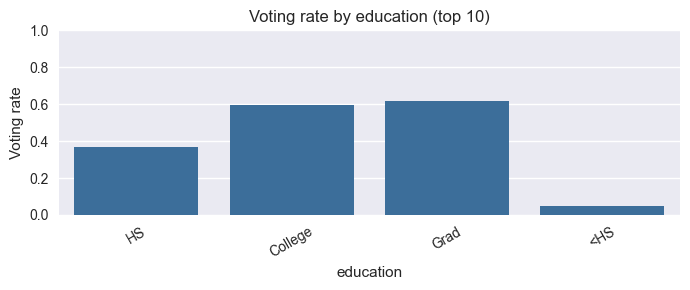

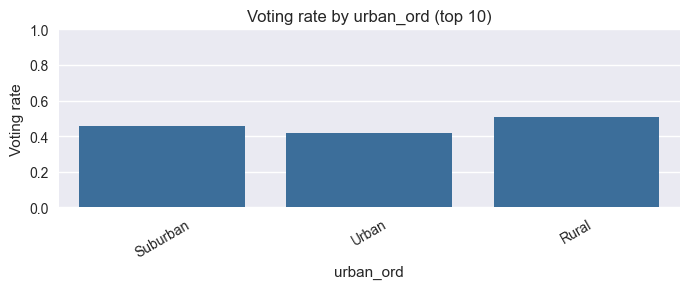

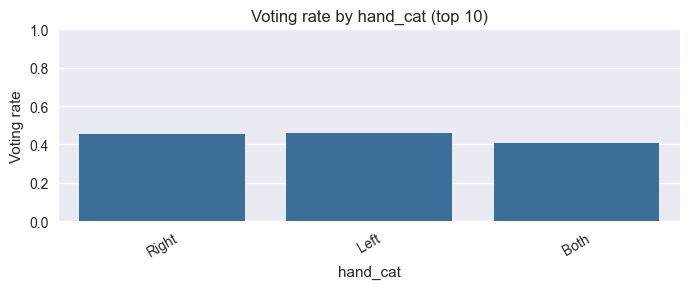

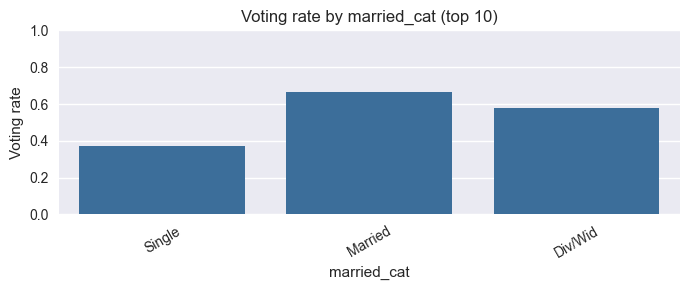

In [24]:
for col in ["age_group_ord", "education", "urban_ord"]:
    if col in df_feat.columns:
        plot_categorical(df_feat, col, top_n=10)

for col in ["hand_cat", "married_cat"]:
    if col in df_feat.columns:
        plot_categorical(df_feat, col, top_n=10)


## 9. 원본 범주형 (race/religion)


**해석 가이드**
- **race/religion**: 상위 빈도 카테고리 중심으로 투표율 차이 확인


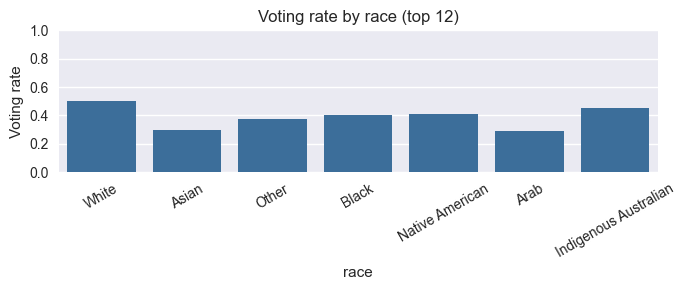

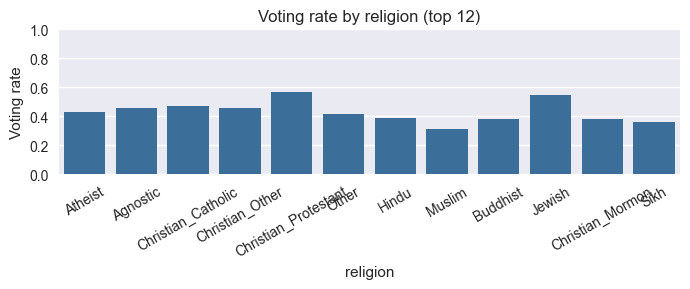

In [25]:
for col in ["race", "religion"]:
    if col in df_feat.columns:
        plot_categorical(df_feat, col, top_n=12)
